In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/train", transform=transform)
val_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/val", transform=transform)
test_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
num_classes = len(class_names)
print("✅ Classes:", class_names)


✅ Classes: ['1', '2', '3', '4', '5', '6', '7']


In [3]:
import sys
sys.path.append("/home/enulu/Workspace/cv_term_project_FER/models/ResEmoteNet/approach")  # This is where the model is

from ResEmoteNet import ResEmoteNet

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResEmoteNet().to(device)


In [4]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [5]:


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total


In [6]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.5131 | Train Acc: 0.4365 | Val Acc: 0.5004
Epoch 2/10 | Avg Loss: 1.1734 | Train Acc: 0.5776 | Val Acc: 0.5837
Epoch 3/10 | Avg Loss: 0.9700 | Train Acc: 0.6685 | Val Acc: 0.6629
Epoch 4/10 | Avg Loss: 0.8315 | Train Acc: 0.7172 | Val Acc: 0.6620
Epoch 5/10 | Avg Loss: 0.7015 | Train Acc: 0.7617 | Val Acc: 0.6865
Epoch 6/10 | Avg Loss: 0.5933 | Train Acc: 0.7997 | Val Acc: 0.6963
Epoch 7/10 | Avg Loss: 0.4900 | Train Acc: 0.8346 | Val Acc: 0.6906
Epoch 8/10 | Avg Loss: 0.3991 | Train Acc: 0.8669 | Val Acc: 0.7110
Epoch 9/10 | Avg Loss: 0.3090 | Train Acc: 0.8983 | Val Acc: 0.6988
Epoch 10/10 | Avg Loss: 0.2432 | Train Acc: 0.9194 | Val Acc: 0.7004


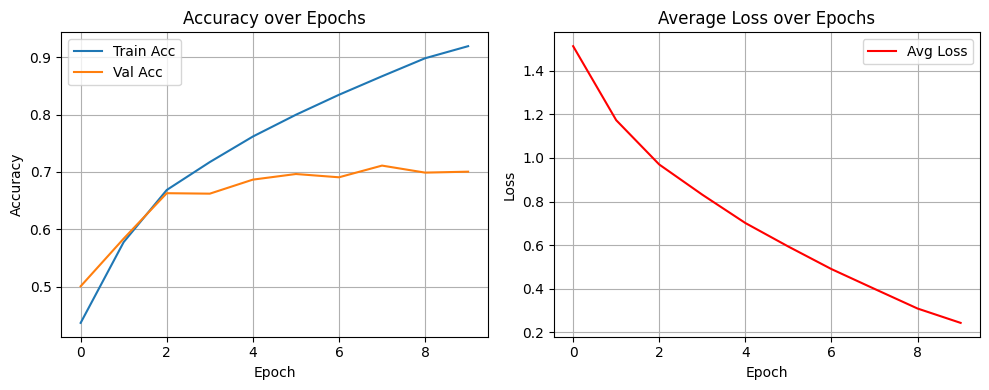

In [7]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.7162

🔍 Classification Report:

              precision    recall  f1-score   support

           1       0.74      0.76      0.75       329
           2       0.74      0.19      0.30        74
           3       0.33      0.42      0.37       160
           4       0.82      0.94      0.87      1185
           5       0.79      0.44      0.57       478
           6       0.72      0.47      0.57       162
           7       0.65      0.74      0.69       680

    accuracy                           0.73      3068
   macro avg       0.68      0.57      0.59      3068
weighted avg       0.74      0.73      0.72      3068



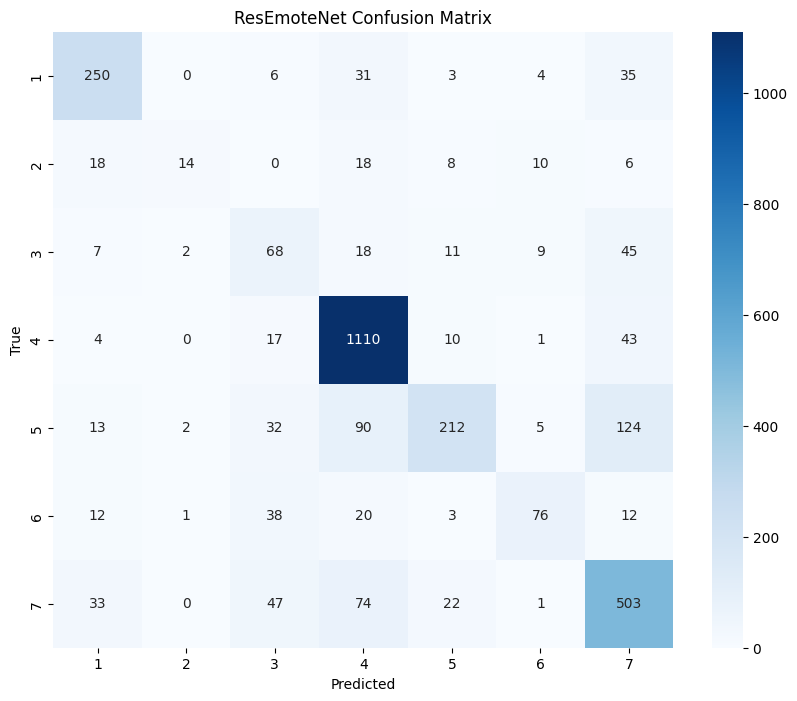

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# ✅ Classification Report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("ResEmoteNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
